In [85]:
import logging
from pprint import pprint
import pandas as pd
import numpy as np
import statsmodels as sm
from statsmodels.tsa.stattools import kpss, adfuller
from matplotlib import pyplot as plt


In [94]:
def kpss_test(series, rejection_criteria=None):
    if rejection_criteria is None:
        rejection_criteria=0.05
    statistic, p_value, n_lags, critical_values = kpss(series, nlags='auto')
    result = "not stationary" if p_value < rejection_criteria else "stationary"
    logging.warning("%r", f"statistic = {statistic}")
    logging.warning("%r", f"p_value = {p_value}")
    logging.warning("%r", f"n_lags = {n_lags}")
    logging.warning("%r", f"critical_values = {critical_values}")
    return p_value,result

def adf_test(series,rejection_criteria=None):
    if rejection_criteria is None:
        rejection_criteria=0.05
    (adf,p_value,usedlag,nobs,critical_values,icbest) = adfuller(series, autolag='AIC')
    result = "stationary" if p_value < rejection_criteria else "not stationary"
    logging.warning("%r", f"adf = {adf}")
    logging.warning("%r", f"p_value = {p_value}")
    logging.warning("%r", f"usedlag = {usedlag}")
    logging.warning("%r", f"nobs = {nobs}")
    logging.warning("%r", f"critical_values = {critical_values}")
    logging.warning("%r", f"icbest = {icbest}")    
    return p_value, result

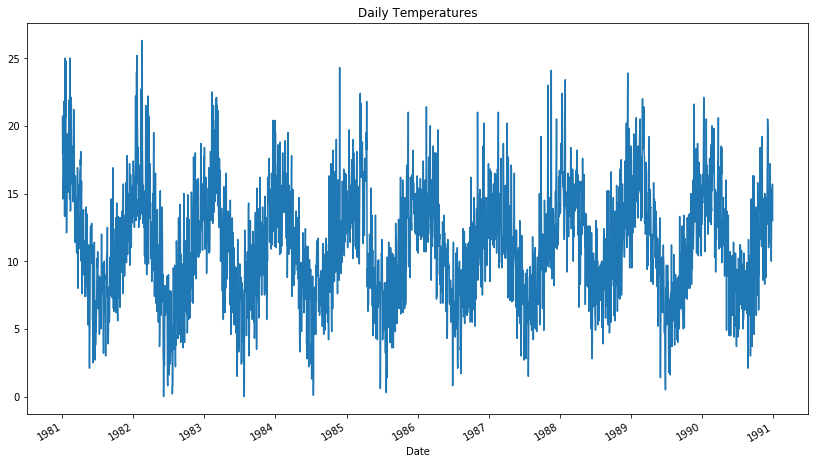

In [95]:
path = 'https://raw.githubusercontent.com/selva86/datasets/master/daily-min-temperatures.csv'
temp_df = pd.read_csv(path, parse_dates=['Date'], index_col='Date')
temp_df.plot(title='Daily Temperatures', figsize=(14,8), legend=None);

In [96]:
kpss_test(temp_df['Temp'])

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


(0.1, 'stationary')

In [97]:
adf_test(temp_df['Temp'])

(0.0002470826300360895, 'stationary')

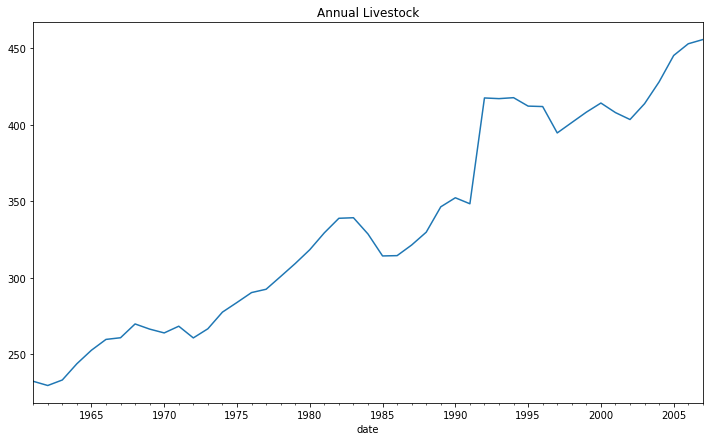

In [98]:
path = 'https://raw.githubusercontent.com/selva86/datasets/master/livestock.csv'
livestock_df = pd.read_csv(path, parse_dates=['date'], index_col='date')
livestock_df.plot.line(title='Annual Livestock', figsize=(12,7), legend=None)

In [99]:
kpss_test(df['value'])

/home/thom/venv36/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


(0.01, 'not stationary')

In [100]:
adf_test(df['value'])

(0.9337890318823667, 'not stationary')